In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch

## Création du jeu de données

On va créer des données avec une structure particulière.

### Rangement des images par label

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [ ]:
test_images, test_labels=torch.tensor(test_images.astype(np.float32)),torch.tensor(test_labels.astype(np.float32))
train_images, train_labels=torch.tensor(train_images.astype(np.float32)),torch.tensor(train_labels.astype(np.float32))

In [ ]:
test_images.shape

In [ ]:
def preprocess(images,labels):
    images_bin=(images>125).to(torch.float32)
    dico={}
    for i in range(10):
        dico[i]=images_bin[labels==i]
    return dico

In [ ]:
DICO_TEST=preprocess(test_images,test_labels)
DICO_TRAIN=preprocess(train_images,train_labels)

#### ♡

***A vous:***
* Qu'y a-t-il dans  `DICO_TEST[3]`? Est-ce que les différents tenseurs `DICO_TRAIN[i]` on la même shape?
* Savez-vous pourquoi j'ai mis les variables `DICO_TEST` et `DICO_Train` en lettres majuscures ; c'est une convention assez classique, vous pouvez la déduire en regardant la structure du programme.

### Le distributeur de données

In [ ]:
def make_XY(dico,batch_size,add_one=True):
    X=[]
    Y=[]
    ensemble_len=np.random.randint(5,13)
    for i in range(batch_size):
        j=np.random.randint(10)
        imgs=dico[j]
        nb_imgs=imgs.shape[0]
        indices_selected=np.random.randint(0, nb_imgs, size=ensemble_len)

        x=imgs[indices_selected]
        if add_one:
            x+=1
        mask=torch.rand(*x.shape)>0.95
        x=x*mask
        X.append(x)

        Y.append(j)

    X = torch.stack(X,dim=0)
    Y = torch.tensor(Y)
    return X,Y

Testons

In [ ]:
for _ in range(3):
    X,Y=make_XY(DICO_TEST,8)
    print(X.shape,Y)

### Visualisation et explication

In [ ]:
def plot_XY(X,Y):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i,nb_j,figsize=(nb_j,nb_i))
    for i in range(nb_i):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        for j in range(x.shape[0]):
            axs[i,j].set_title(f"{Y[i]}")
            axs[i,j].imshow(x[j,:,:].cpu(),vmin=0,vmax=2)
    fig.tight_layout()

In [ ]:
X,Y=make_XY(DICO_TEST,3)
plot_XY(X,Y)

In [ ]:
X,Y=make_XY(DICO_TEST,3)
plot_XY(X,Y)

* Une donnée d'entrée $x$ c'est un ensemble d'images détériorées, toutes du même chiffre.
Cet ensemble n'est pas ordonné et il est de taille variable (comme la plupart des ensemble dans le domaine de "l'apprentissage d'ensemble").

* Une sortie $y$ est le chiffre correspondant aux images dans $x$.

* Un batch $X$ c'est un ensemble de données $x$ (ne provenant pas tous du même chiffre). Par contre au sein d'un même batch, les ensemble ont la même taille (pour qu'on puisse utiliser  des tenseurs). Mais d'un batch à l'autre la ensembles peuvent avoir des tailles différentes.

### Modifier un peu les données

#### ♡♡♡

***A vous:*** Dans `make_XY`:

* Si l'on met `add_one=False`, est-ce que les données sont plus facile ou plus difficile à analyser? Justifiez.
* Il y a une constante très importante qui gére la détérioration des données. C'est laquelle?
* Modifier  `make_XY` pour que cette constante que l'on appélera `deterioration_rate` apparaissent dans la signature de la fonction, qui déviendra donc:  

        def make_XY(dico,batch_size,add_one=True,deterioration_rate=...)


Remarque: si cette constante vaut 0, les images ne sont pas du tout détériorées. A l'inverse, si elle vaut 1, les images sont impossible à reconnaitre.

### Créons un modèle


Créons un modèle simple adapté a nos données. Et testons qu'il est bien invariant par permutation des éléments des ensembles.

#### ♡♡♡♡♡♡

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_model=64


        self.input_layer=torch.nn.Linear(...


        self.lays=torch.nn.ModuleList()

        for _ in range(3):
            self.lays.append(torch.nn.Linear(d_model,d_model))

        self.lays_after=torch.nn.ModuleList()
        for _ in range(3):
            self.lays_after.append(torch.nn.Linear(d_model,d_model))


        self.final_layer=torch.nn.Linear(...



    def forward(self,X):
        b,n,h,w=X.shape
        assert (h,w)==(28,28)

        #applatissement
        X=torch.reshape(X,[...,...,...]))
        #maintenant X est  un tenseur de dimension 3.

        X = self.input_layer(X)
        for lay in self.lays:
            #on modifie les données élément par élément (= en ajissant uniquement sur la dernière dimension des tenseurs)
            X=torch.relu(lay(X))

        H = torch.amax(
        #H est maintenant un tenseur de dimension 2. On a une 'global feature' de l'ensemble.

        for lay in self.lays_after:
            H = torch.relu(lay(H))

        return self.final_layer(H)

def test_model():
    X,Y=make_XY(DICO_TEST,3)
    n = X.shape[1]
    perm=np.random.permutation(n)
    X_ = X[:,perm,:,:]

    model=Model()
    Y=model(X)
    Y_=model(X_)
    print(X.shape,Y.shape)

    assert torch.allclose(Y,Y_)

test_model()

### Créons un meilleurs modèle


Dans le modèle précédent, nous n'avons pas pris en compte le fait que les éléments des ensembles étaient des images. Modifions cela.

#### ♡♡♡♡♡♡


In [ ]:
class Model_conv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_model=32
        self.d_model=d_model

        #Image noir et blanc=> 1 channel en entrée
        self.input_layer=torch.nn.Conv2d(...

        self.lays=torch.nn.ModuleList()
        for _ in range(3):
            self.lays.append(torch.nn.Conv2d(d_model,d_model,3,padding="same"))


        self.compressor_layer=torch.nn.Linear(...


        self.lays_after=torch.nn.ModuleList()
        for _ in range(3):
            self.lays_after.append(torch.nn.Linear(d_model,d_model))


        self.final_layer=torch.nn.Linear(...


    def forward(self,X):
        b,n,h,w=X.shape
        assert (h,w)==(28,28)
        X=torch.reshape(X,[...,...,...,...])
        #X est maintenant un tenseur de dimesion 4: c'est un batch d'images

        X = self.input_layer(X)


        for lay in self.lays:
            X=torch.relu(lay(X))


        #il faut faire réapparaitre le 'n' qui est le nombre d'élément dans l'ensemble
        X=torch.reshape(X,[...,...,...,...,...])

        H = torch.amax(
        #Maintenant H est invariante par permutation des éléments de l'ensemble.


        H = torch.reshape(...
        #maintenant H est une data-frame.
        #On va réduire sa dimension, puis la faire passer dans un réseau dense.
        H = self.compressor_layer(H)

        for lay in self.lays_after:
            H = torch.relu(lay(H))

        return self.final_layer(H)

def test_model():
    X,Y=make_XY(DICO_TEST,3)
    n = X.shape[1]
    perm=np.random.permutation(n)
    X_ = X[:,perm,:,:]

    model=Model_conv()
    Y=model(X)
    Y_=model(X_)
    print(X.shape,Y.shape)

    assert torch.allclose(Y,Y_)

test_model()

###Variante+:




#### ♡♡♡♡♡♡♡

On n'a pas mix de max-pooling 2d dans l'analyse des images. Dommage, c'est un bon moyen de compresser l'information.

Ajoutez-en un juste avant l'application du `compressor_layer`. Cela réduit beaucoup son nombre de paramètres.



### Variante++


#### ♡♡

Sans ajouter de code: indiquez quels sont les éléments que l'on pourrait ajouter à cette architecture.

### Entrainez !

#### ♡♡♡♡♡♡♡♡♡♡♡
Créez un Agent torch. Apprenez ce jeu de donnée.

Dans un premier temps utiliser une détérioration faible pour que votre modèle apprennent facilement.


On essaiera d'utiliser au mieux la structure des données dans l'architecture du modèle.


On peut faire des copié-collé d'autre TP. Notamment d'un agent.

Il faut bien présenter ses résultats. Des images avec les étiquettes prédites au


## Reconstruction des images

Changeons de données.

### Le distributeur de données

In [ ]:
def make_XY2(dico,batch_size,add_one=True):
    X=[]
    Y=[]
    ensemble_size=np.random.randint(5,13)
    for i in range(batch_size):
        j=np.random.randint(10)
        imgs=dico[j]
        nb_imgs=imgs.shape[0]
        indices_selected=np.random.randint(0, nb_imgs, size=ensemble_size)

        x=imgs[indices_selected]
        y=x*1 #pour faire une copie

        if add_one:#uniquement pour x
            x+=1


        mask=torch.rand(*x.shape)>0.8
        x=x*mask
        X.append(x)
        Y.append(y)

    X=torch.stack(X,dim=0)
    Y=torch.stack(Y,dim=0)


    return X,Y

Testons

In [ ]:
X,Y=make_XY2(DICO_TEST,8)
X.shape,Y.shape

### Visualisation et explication

In [ ]:
def plot_XY2(X,Y):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i*2,nb_j,figsize=(nb_j,nb_i*2))
    for i in range(nb_i*2):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        y=Y[i]
        for j in range(x.shape[0]):
            axs[2*i,j].imshow(x[j,:,:].cpu(),vmin=0,vmax=2)
            axs[2*i+1,j].imshow(y[j,:,:].cpu(),vmin=0,vmax=1)

    fig.tight_layout()

In [ ]:
X,Y=make_XY2(DICO_TEST,3)
plot_XY2(X,Y)

In [ ]:
X,Y=make_XY2(DICO_TEST,3)
plot_XY2(X,Y)

### Créez un modèle, entrainez-le !

#### ♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡


Créez un modèle qui permet de retrouver les ensemble d'images à partir de leur versions détériorées.

Même si ce n'est pas obligatoire: un bonus sera accordé si votre modèle utilise une "global-feature" propre à l'ensemble (donc invariante par permutation).

Le résultat final du modèle n'est pas invariant par permutation (of course).

#### ♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡

Et pourquoi pas, dans un second temps, de reconstituer les images et en même temps d'y ajouter la bonne étiquette. On aura donc un modèle qui ressort un ensemble d'images et une étiquette.

### Exemple de résultat

La fonction ci-dessous pourra vous aider à afficher vos résultats

In [ ]:
def plot_XY2_pred(X,Y,Y_pred):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i*4,nb_j,figsize=(nb_j,nb_i*4))
    for i in range(nb_i*4):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        y=Y[i]
        y_pred=Y_pred[i]
        for j in range(x.shape[0]):
            axs[4*i,j].imshow(x[j,:,:],vmin=0,vmax=2)
            axs[4*i+1,j].imshow(y[j,:,:],vmin=0,vmax=1)
            axs[4*i+2,j].imshow(y_pred[j,:,:],vmin=0,vmax=1)

    fig.tight_layout()

Cela pourrait donner ce genre de graphique:

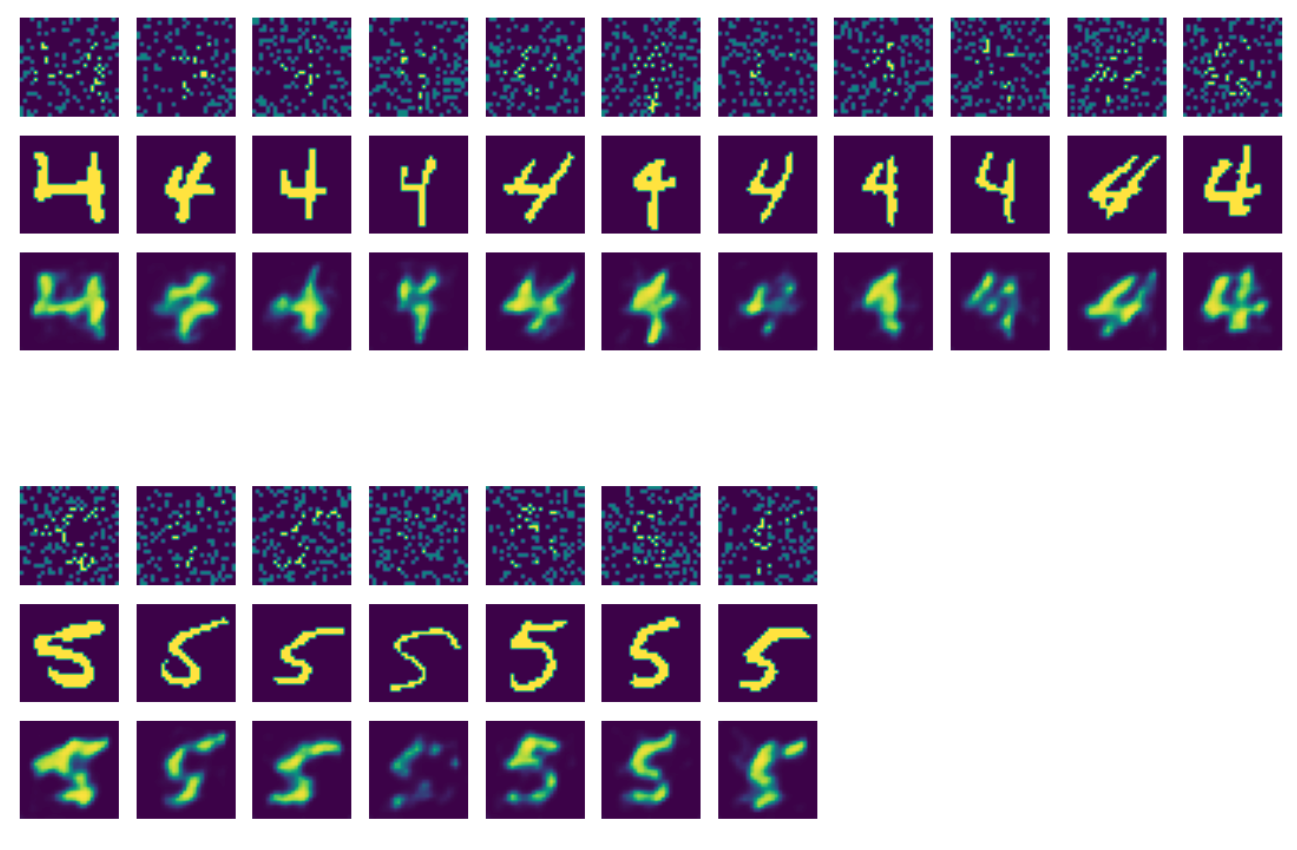

Avec un seuillage final, cela pourrait être encore mieux